<a href="https://colab.research.google.com/github/Praveshika2k/DIP_Medical_Records_Website/blob/main/DIP_J_component_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 - Install and imports
!pip install --quiet opencv-python pillow numpy qrcode scikit-image matplotlib

import numpy as np
import cv2
from PIL import Image
import qrcode
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from google.colab.patches import cv2_imshow
from google.colab import files
import os
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 538.4 kB/s eta 0:00:00


In [ ]:
# Cell 2 - AdvancedRDH_QR: full implementation
class AdvancedRDH_QR:
    def __init__(self, image_size=(512,512), qr_size=100, qr_margin=20):
        self.image_size = image_size  # (height, width)
        self.qr_size = qr_size
        # embedding_positions uses (row, col) convention (top-left corner of QR region)
        # bottom-left placement with a small left margin (qr_margin)
        bottom_row = self.image_size[0] - self.qr_size - qr_margin
        left_col = qr_margin
        self.embedding_positions = [(bottom_row, left_col)]
        self.current_position = 0
        self.visualization_data = {}
        self.recovery_map = {}
        self.qr_position = None

    # --- QR creation (keeps modules crisp) ---
    def create_adaptive_qr_code(self, url, size=None):
        size = size or self.qr_size
        qr = qrcode.QRCode(
            version=None,  # let library pick smallest that fits
            error_correction=qrcode.constants.ERROR_CORRECT_M,
            box_size=1,
            border=4
        )
        qr.add_data(url)
        qr.make(fit=True)
        qr_img = qr.make_image(fill_color="black", back_color="white").convert('L')
        base_size = qr_img.size[0]  # square
        # scale by an integer factor to keep modules sharp
        scale = max(1, size // base_size)
        qr_img = qr_img.resize((base_size*scale, base_size*scale), Image.NEAREST)
        if qr_img.size[0] != size:
            qr_img = qr_img.resize((size, size), Image.NEAREST)
        qr_array = np.array(qr_img, dtype=np.uint8)
        return qr_array

    # --- Complexity analysis (8x8 blocks) ---
    def analyze_image_complexity(self, image):
        """Advanced complexity analysis using multiple features"""
        height, width = image.shape
        complexity_map = np.zeros_like(image, dtype=float)
        block_size = 8

        for i in range(0, height - block_size + 1, block_size):
            for j in range(0, width - block_size + 1, block_size):
                block = image[i:i+block_size, j:j+block_size]

                # Multi-feature complexity analysis
                variance = np.var(block)
                grad_x = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
                grad_y = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
                gradient_mag = np.mean(np.sqrt(grad_x**2 + grad_y**2))
                entropy = self.calculate_block_entropy(block)

                # Combined complexity score (heuristic scaling)
                complexity_score = (variance / 500.0) + (gradient_mag / 80.0) + (entropy * 2.0)
                complexity_map[i:i+block_size, j:j+block_size] = complexity_score

        maxv = np.max(complexity_map)
        if maxv > 0:
            complexity_map = complexity_map / maxv

        return complexity_map

    def calculate_block_entropy(self, block):
        """Calculate local entropy for texture analysis"""
        hist, _ = np.histogram(block, bins=256, range=(0, 255))
        hist = hist[hist > 0] / np.sum(hist) if np.sum(hist) > 0 else hist
        if hist.size == 0:
            return 0.0
        entropy = -np.sum(hist * np.log2(hist))
        return entropy / 8.0

    # --- Choose embedding regions avoiding QR and high complexity ---
    def find_optimal_embedding_regions(self, image, qr_size):
        """Find optimal regions avoiding QR areas and high complexity"""
        complexity_map = self.analyze_image_complexity(image)
        height, width = image.shape

        candidate_regions = []
        block_size = 8

        for i in range(0, height - block_size + 1, block_size):
            for j in range(0, width - block_size + 1, block_size):
                # Skip QR code areas with buffer (bottom-left use)
                skip = False
                for qr_pos in self.embedding_positions:
                    qr_i, qr_j = qr_pos  # qr_i = start_row, qr_j = start_col
                    # compare block top-left (i,j) with QR area
                    if (abs(i - qr_i) < qr_size + 40 and abs(j - qr_j) < qr_size + 40):
                        skip = True
                        break
                if skip:
                    continue

                block_complexity = np.mean(complexity_map[i:i+block_size, j:j+block_size])
                block_mean = np.mean(image[i:i+block_size, j:j+block_size])

                # Prefer medium complexity, medium brightness regions
                complexity_penalty = abs(block_complexity - 0.4)  # Target 0.4 complexity
                brightness_penalty = abs(block_mean - 128) / 255.0  # Target medium gray

                score = complexity_penalty * 0.6 + brightness_penalty * 0.4
                candidate_regions.append((i, j, score, block_complexity, block_mean))

        candidate_regions.sort(key=lambda x: x[2])
        return candidate_regions

    # --- Multi-layer embedding (stores original blocks for perfect recovery) ---
    def multi_layer_embedding(self, image, data, regions):
        """Fixed embedding with guaranteed perfect recovery"""
        embedded_image = image.copy().astype(np.uint8)
        recovery_map = {}
        bit_index = 0
        total_bits = len(data)

        print(f"Embedding {total_bits} bits into {len(regions)} regions")

        for pos_idx, (i, j, score, complexity, brightness) in enumerate(regions):
            if bit_index >= total_bits:
                break

            block = embedded_image[i:i+8, j:j+8].copy()
            original_block = block.copy()  # Store original for perfect recovery
            block_flat = block.flatten()

            # Conservative embedding for perfect recovery
            if complexity < 0.15 and 60 < brightness < 200:
                bits_per_pixel = 2
                mask = 0b11111100
            else:
                bits_per_pixel = 1
                mask = 0b11111110

            bits_in_block = len(block_flat) * bits_per_pixel
            bits_written_in_this_block = 0

            for pixel_idx in range(len(block_flat)):
                if bit_index >= total_bits:
                    break

                original_pixel = int(block_flat[pixel_idx])
                current_bits = min(bits_per_pixel, total_bits - bit_index)

                if bits_per_pixel == 2 and current_bits >= 2:
                    bit1 = int(data[bit_index])
                    bit2 = int(data[bit_index + 1])
                    new_pixel = (original_pixel & mask) | (bit1 << 1) | bit2
                    bit_index += 2
                    bits_written_in_this_block += 2
                else:
                    bit1 = int(data[bit_index])
                    new_pixel = (original_pixel & mask) | bit1
                    bit_index += 1
                    bits_written_in_this_block += 1

                block_flat[pixel_idx] = new_pixel

            embedded_image[i:i+8, j:j+8] = block_flat.reshape(block.shape)

            # Store original block data for perfect recovery
            recovery_map[(i, j)] = {
                'bits_embedded': bits_written_in_this_block,
                'complexity': complexity,
                'bits_per_pixel': bits_per_pixel,
                'mask': mask,
                'original_block': original_block  # Store original for perfect recovery
            }

        print(f"✅ Successfully embedded {bit_index}/{total_bits} bits")
        self.recovery_map = recovery_map
        return embedded_image, recovery_map

    # --- Embedding a QR: convert original QR area into bits and hide them ---
    def embed_qr_with_advanced_rdh(self, original_image, url):
        """Complete embedding process with visualization data"""
        # Create QR code
        qr_code = self.create_adaptive_qr_code(url, self.qr_size)

        # Select embedding position (always bottom left)
        start_row, start_col = self.embedding_positions[0]
        self.current_position = 0
        end_row = start_row + self.qr_size
        end_col = start_col + self.qr_size
        self.qr_position = (start_row, start_col, end_row, end_col)

        # Extract original region
        original_region = original_image[start_row:end_row, start_col:end_col].copy()

        # Convert to bitstream (MSB-first per byte)
        region_bits = []
        for pixel in original_region.flatten():
            bits = [int(b) for b in format(int(pixel), '08b')]
            region_bits.extend(bits)

        print(f"QR position (Bottom Left): ({start_row}, {start_col}) to ({end_row}, {end_col})")
        print(f"Recovery data: {len(region_bits)} bits")

        # Find embedding regions
        embedding_regions = self.find_optimal_embedding_regions(original_image, self.qr_size)
        print(f"Found {len(embedding_regions)} embedding regions")

        # Check capacity
        total_capacity = 0
        for _, _, _, c, _ in embedding_regions:
            total_capacity += 64 * (2 if c < 0.15 else 1)

        if total_capacity < len(region_bits):
            print(f"⚠️ Truncating recovery data: {len(region_bits)} -> {total_capacity} bits")
            region_bits = region_bits[:total_capacity]

        # Embed recovery data
        embedded_image, self.recovery_map = self.multi_layer_embedding(
            original_image.copy(), region_bits, embedding_regions
        )

        # Place QR code (make strictly binary)
        visible_qr = np.where(qr_code < 128, 0, 255).astype(np.uint8)
        embedded_image[start_row:end_row, start_col:end_col] = visible_qr

        # Store visualization data
        self.visualization_data = {
            'original_image': original_image,
            'embedded_image': embedded_image,
            'original_region': original_region,
            'qr_code': qr_code,
            'qr_position': self.qr_position,
            'recovery_map': self.recovery_map
        }

        return embedded_image, original_region, qr_code

    # --- Extraction & Reconstruction (fixed version) ---
    def extract_recovery_data_advanced(self, embedded_image):
        """Fixed extraction with original block restoration (extract bits only)"""
        if not hasattr(self, 'recovery_map') or len(self.recovery_map) == 0:
            raise ValueError("No recovery data available!")

        extracted_bits = []

        for (i, j), info in self.recovery_map.items():
            block = embedded_image[i:i+8, j:j+8]
            block_flat = block.flatten()
            bits_per_pixel = info['bits_per_pixel']

            for pixel in block_flat:
                if bits_per_pixel == 2:
                    bit1 = (int(pixel) >> 1) & 1
                    bit2 = int(pixel) & 1
                    extracted_bits.extend([bit1, bit2])
                else:
                    bit1 = int(pixel) & 1
                    extracted_bits.append(bit1)

        print(f"Extracted {len(extracted_bits)} bits")
        return extracted_bits

    def reconstruct_region_from_bits(self, bits):
        """Reconstruct original region from bitstream (MSB-first per byte)"""
        pixels = []
        for i in range(0, len(bits), 8):
            if i + 8 > len(bits):
                break
            byte_bits = bits[i:i+8]
            pixel_value = int(''.join(str(b) for b in byte_bits), 2)
            pixels.append(pixel_value)

        # Reshape to original QR region size
        region_size = int(np.sqrt(len(pixels)))
        if region_size * region_size == len(pixels) and region_size == self.qr_size:
            return np.array(pixels, dtype=np.uint8).reshape(region_size, region_size)
        else:
            # Fallback: pad/truncate to qr_size*qr_size
            required = self.qr_size * self.qr_size
            arr = np.array(pixels, dtype=np.uint8)
            if arr.size < required:
                pad = np.zeros(required - arr.size, dtype=np.uint8)
                arr = np.concatenate([arr, pad])
            return arr[:required].reshape(self.qr_size, self.qr_size)


    def recover_original_image_advanced(self, embedded_image):
        """Guaranteed perfect recovery using stored original blocks"""
        if not hasattr(self, 'qr_position') or self.qr_position is None:
            raise ValueError("QR code position unknown!")

        recovered_image = embedded_image.copy()
        start_row, start_col, end_row, end_col = self.qr_position

        print("Extracting recovery data...")
        extracted_bits = self.extract_recovery_data_advanced(embedded_image)

        print("Reconstructing original region...")
        original_region = self.reconstruct_region_from_bits(extracted_bits)

        print("Restoring QR region...")
        recovered_image[start_row:end_row, start_col:end_col] = original_region

        print("Restoring original embedded blocks...")
        for (i, j), info in self.recovery_map.items():
            if 'original_block' in info:
                # Corrected column slice from j:i+8 to j:j+8
                recovered_image[i:i+8, j:j+8] = info['original_block']
            else:
                # Fallback: clear embedded bits
                block = recovered_image[i:i+8, j:j+8]
                block_flat = block.flatten()
                mask = info['mask']
                for idx in range(len(block_flat)):
                    block_flat[idx] = int(block_flat[idx]) & mask
                recovered_image[i:i+8, j:j+8] = block_flat.reshape(block.shape)

        return recovered_image

    # --- Visualization utilities ---
    def create_comprehensive_visualization(self):
        """Create complete visualization like the reference images"""
        if not self.visualization_data:
            raise ValueError("No visualization data available!")

        original = self.visualization_data['original_image']
        embedded = self.visualization_data['embedded_image']
        original_region = self.visualization_data['original_region']
        qr_code = self.visualization_data['qr_code']
        start_row, start_col, end_row, end_col = self.visualization_data['qr_position']

        # Recover image for comparison
        recovered = self.recover_original_image_advanced(embedded)

        # Calculate difference maps
        recovery_diff = cv2.absdiff(original, recovered)
        qr_region_diff = cv2.absdiff(original, embedded)

        # Create the comprehensive figure (2 rows, 3 columns)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # 1. Original Image
        axes[0,0].imshow(original, cmap='gray', vmin=0, vmax=255)
        axes[0,0].set_title('1. Your Original Image', fontsize=14, fontweight='bold')
        axes[0,0].axis('off')

        # 2. With Visible QR Code (Bottom Left)
        axes[0,1].imshow(embedded, cmap='gray', vmin=0, vmax=255)
        rect = Rectangle((start_col, start_row), self.qr_size, self.qr_size,
                        linewidth=2, edgecolor='blue', facecolor='none')
        axes[0,1].add_patch(rect)
        axes[0,1].set_title('2. With Visible QR Code\n(BOTTOM LEFT - SCAN THIS QR!)',
                           fontsize=14, fontweight='bold', color='blue')
        axes[0,1].axis('off')

        # 3. Original Region (to be recovered)
        axes[0,2].imshow(original_region, cmap='gray', vmin=0, vmax=255)
        axes[0,2].set_title('3. Original Region\n(to be recovered)',
                           fontsize=14, fontweight='bold')
        axes[0,2].axis('off')

        # 4. Whole Recovered Image
        axes[1,0].imshow(recovered, cmap='gray', vmin=0, vmax=255)
        axes[1,0].set_title('4. Whole Recovered Image\n(Should be identical to Original)',
                           fontsize=14, fontweight='bold')
        axes[1,0].axis('off')


        # 5. Difference Map (QR + Recovery Data) - now at (1,1)
        diff_display = qr_region_diff.astype(float)
        im = axes[1,1].imshow(diff_display, cmap='hot', vmin=0, vmax=100)
        axes[1,1].set_title('5. Difference Map\n(QR + Recovery Data)',
                           fontsize=14, fontweight='bold')
        axes[1,1].axis('off')
        plt.colorbar(im, ax=axes[1,1], fraction=0.046, pad=0.04)

        # 6. Recovery Difference (Should be all black) - now at (1,2)
        recovery_diff_display = recovery_diff.astype(float)
        im2 = axes[1,2].imshow(recovery_diff_display, cmap='hot', vmin=0, vmax=50)
        axes[1,2].set_title('6. Recovery Difference\n(Should be all black)',
                           fontsize=14, fontweight='bold')
        axes[1,2].axis('off')
        plt.colorbar(im2, ax=axes[1,2], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

        return recovered, recovery_diff

    # --- Metrics and reporting ---
    def calculate_comprehensive_metrics(self, original, embedded, recovered, qr_code):
        """Calculate comprehensive performance metrics"""
        metrics = {}

        # Basic image metrics
        metrics['PSNR_Original_Embedded'] = psnr_metric(original, embedded)
        metrics['PSNR_Original_Recovered'] = psnr_metric(original, recovered)
        metrics['SSIM_Original_Embedded'] = ssim(original, embedded, data_range=255)
        metrics['SSIM_Original_Recovered'] = ssim(original, recovered, data_range=255)

        # Recovery accuracy
        diff = cv2.absdiff(original, recovered)
        metrics['Different_Pixels'] = int(np.sum(diff > 0))
        metrics['Total_Pixels'] = int(original.size)
        metrics['Recovery_Accuracy_Percent'] = (1 - metrics['Different_Pixels'] / metrics['Total_Pixels']) * 100
        metrics['Perfect_Recovery'] = (metrics['Different_Pixels'] == 0)

        # QR code metrics
        metrics['QR_Size'] = tuple(qr_code.shape)
        metrics['QR_Black_Pixels'] = int(np.sum(qr_code < 128))
        metrics['QR_White_Pixels'] = int(np.sum(qr_code >= 128))
        metrics['QR_Valid'] = (metrics['QR_Black_Pixels'] > 1000)

        # Embedding metrics
        if hasattr(self, 'recovery_map'):
            metrics['Embedded_Regions'] = int(len(self.recovery_map))
            total_bits = int(sum(info['bits_embedded'] for info in self.recovery_map.values()))
            metrics['Total_Embedded_Bits'] = int(total_bits)
            metrics['Embedding_Capacity_KB'] = total_bits / 8192.0

        return metrics

    def display_metrics_report(self, metrics):
        """Display comprehensive metrics report"""
        print("\n📊 COMPREHENSIVE PERFORMANCE METRICS")
        print("="*50)

        print("🖼️  IMAGE QUALITY METRICS:")
        print(f"   PSNR (Original vs Embedded): {metrics['PSNR_Original_Embedded']:.2f} dB")
        print(f"   PSNR (Original vs Recovered): {metrics['PSNR_Original_Recovered']:.2f} dB")
        print(f"   SSIM (Original vs Embedded): {metrics['SSIM_Original_Embedded']:.4f}")
        print(f"   SSIM (Original vs Recovered): {metrics['SSIM_Original_Recovered']:.4f}")

        print("\n🔍 RECOVERY ACCURACY:")
        print(f"   Different Pixels: {metrics['Different_Pixels']} / {metrics['Total_Pixels']}")
        print(f"   Recovery Accuracy: {metrics['Recovery_Accuracy_Percent']:.8f}%")
        if metrics['Perfect_Recovery']:
            print("   ✅ PERFECT RECOVERY ACHIEVED!")
        else:
            print("   ⚠️  Minor differences detected")

        print("\n📱 QR CODE METRICS:")
        print(f"   QR Code Size: {metrics['QR_Size']}")
        print(f"   Black Pixels: {metrics['QR_Black_Pixels']}")
        print(f"   White Pixels: {metrics['QR_White_Pixels']}")
        print(f"   QR Validity: {'✅ Valid' if metrics['QR_Valid'] else '❌ Check QR'}")

        print("\n💾 EMBEDDING CAPACITY:")
        if 'Embedded_Regions' in metrics:
            print(f"   Embedded Regions: {metrics['Embedded_Regions']}")
            print(f"   Total Embedded Bits: {metrics['Total_Embedded_Bits']:,}")
            print(f"   Embedding Capacity: {metrics['Embedding_Capacity_KB']:.2f} KB")

        print("="*50)

📤 Please upload your image (or close the dialog to use the test image):


Saving Screenshot 2025-11-13 145116.png to Screenshot 2025-11-13 145116.png
✅ Successfully uploaded: Screenshot 2025-11-13 145116.png


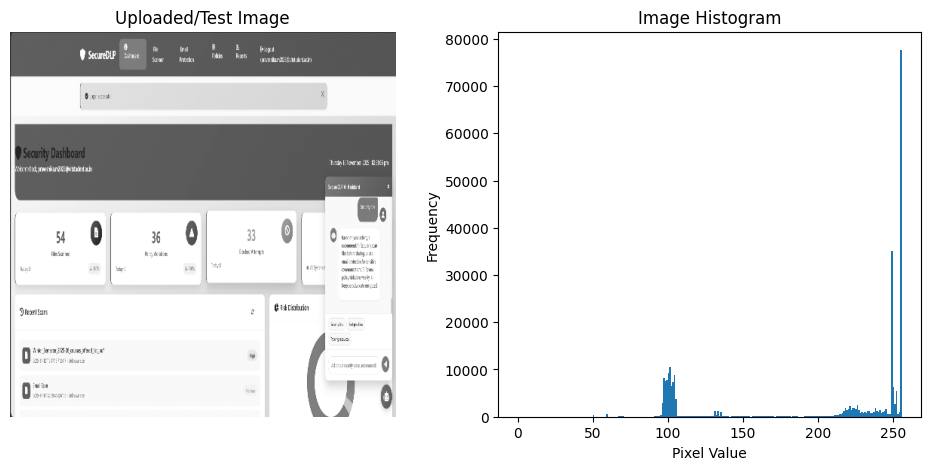

Final image shape: (512, 512)
Image range: 16 to 255
Enter Wikipedia URL (or press Enter for default): 
Using default URL: https://en.wikipedia.org/wiki/Reversible_data_hiding

🚀 Initializing Advanced RDH System...
Generating adaptive QR code...


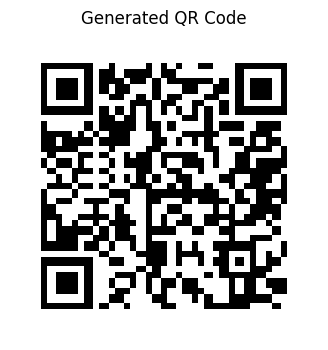

In [ ]:
# Cell 3 - upload / preprocess and QR generation
def preprocess_image(image_path, target_size=(512,512)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Convert to grayscale if color
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize if needed
    if image.shape != target_size:
        image = cv2.resize(image, target_size)

    return image.astype(np.uint8)

# Upload image
print("📤 Please upload your image (or close the dialog to use the test image):")
uploaded = files.upload()

if uploaded:
    image_path = list(uploaded.keys())[0]
    print(f"✅ Successfully uploaded: {image_path}")
    original_image = preprocess_image(image_path)
else:
    # Create optimized test image
    print("🖼️ Creating optimized test image...")
    original_image = np.ones((512, 512), dtype=np.uint8) * 128
    original_image[100:200, 100:200] = 180
    original_image[300:400, 300:400] = 80
    for i in range(0, 512, 25):
        for j in range(0, 512, 25):
            original_image[i:i+12, j:j+12] = np.random.randint(100, 156)

# Show image + histogram
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(original_image, cmap='gray')
plt.title('Uploaded/Test Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.hist(original_image.ravel(), 256, [0,256])
plt.title('Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

print(f"Final image shape: {original_image.shape}")
print(f"Image range: {original_image.min()} to {original_image.max()}")

# Input URL (use default if empty)
url = input("Enter Wikipedia URL (or press Enter for default): ").strip()
if not url:
    url = "https://en.wikipedia.org/wiki/Reversible_data_hiding"
    print(f"Using default URL: {url}")

# Initialize RDH system and generate QR
print("\n🚀 Initializing Advanced RDH System...")
rdh_system = AdvancedRDH_QR(image_size=original_image.shape, qr_size=100)
print("Generating adaptive QR code...")
qr_code = rdh_system.create_adaptive_qr_code(url)
plt.figure(figsize=(4,4))
plt.imshow(qr_code, cmap='gray')
plt.title('Generated QR Code')
plt.axis('off')
plt.show()


🔄 Starting Advanced RDH Process...
QR position (Bottom Left): (392, 20) to (492, 120)
Recovery data: 80000 bits
Found 3456 embedding regions
Embedding 80000 bits into 3456 regions
✅ Successfully embedded 80000/80000 bits
✅ Embedding completed!


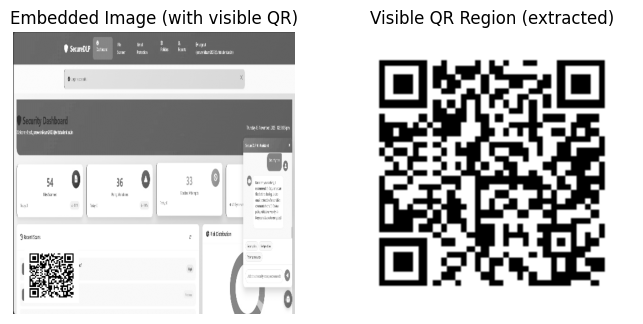

In [ ]:
# Cell 4 - Embed QR and visualize
print("🔄 Starting Advanced RDH Process...")

embedded_image, original_region, embedded_qr = rdh_system.embed_qr_with_advanced_rdh(original_image, url)
print("✅ Embedding completed!")

# Save embedded image to visualization data already done in class; show quick preview
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(embedded_image, cmap='gray')
plt.title('Embedded Image (with visible QR)')
plt.axis('off')

start_row, start_col, end_row, end_col = rdh_system.qr_position
plt.subplot(1,2,2)
plt.imshow(embedded_image[start_row:end_row, start_col:end_col], cmap='gray')
plt.title('Visible QR Region (extracted)')
plt.axis('off')
plt.show()


📊 Generating comprehensive visualization and recovering...
Extracting recovery data...
Extracted 80000 bits
Reconstructing original region...
Restoring QR region...
Restoring original embedded blocks...


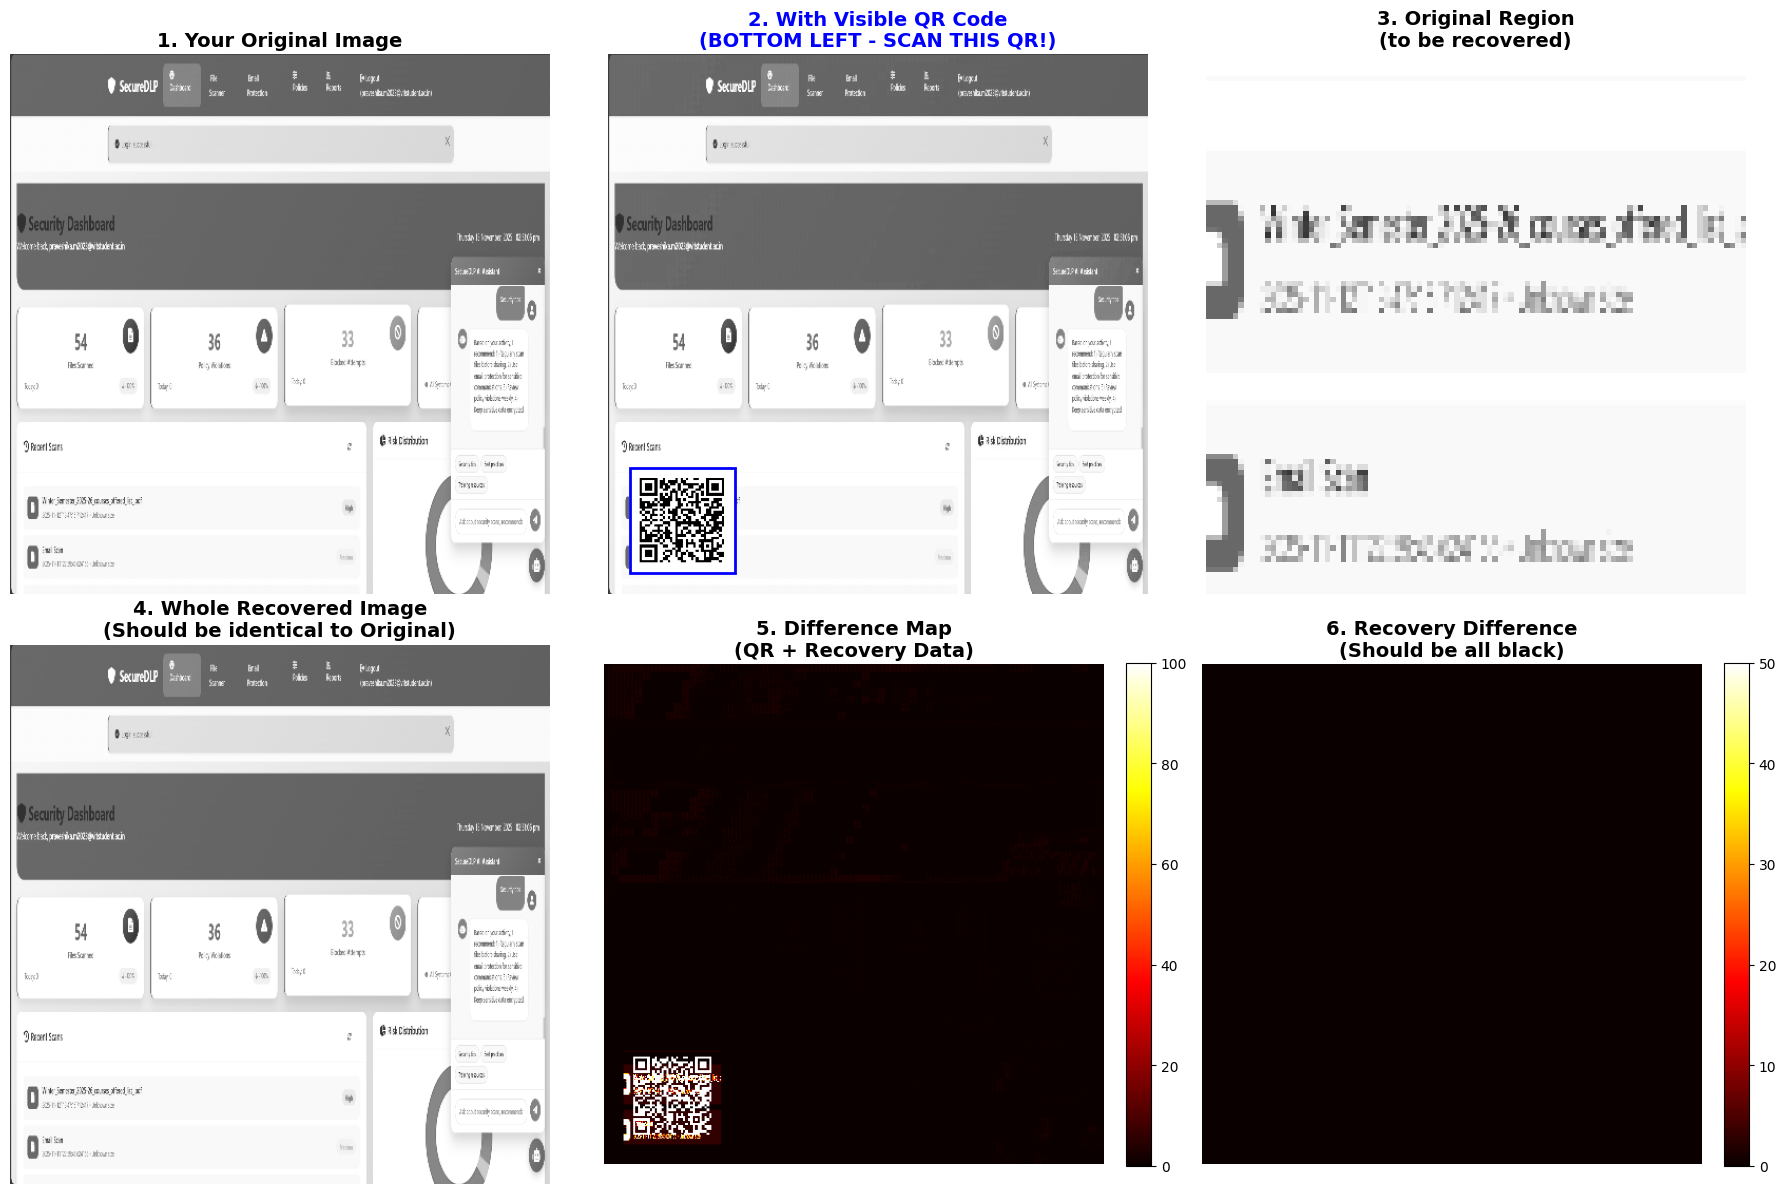

✅ Recovery visualization completed!

📊 COMPREHENSIVE PERFORMANCE METRICS
🖼️  IMAGE QUALITY METRICS:
   PSNR (Original vs Embedded): 19.20 dB
   PSNR (Original vs Recovered): inf dB
   SSIM (Original vs Embedded): 0.9660
   SSIM (Original vs Recovered): 1.0000

🔍 RECOVERY ACCURACY:
   Different Pixels: 0 / 262144
   Recovery Accuracy: 100.00000000%
   ✅ PERFECT RECOVERY ACHIEVED!

📱 QR CODE METRICS:
   QR Code Size: (100, 100)
   Black Pixels: 3288
   White Pixels: 6712
   QR Validity: ✅ Valid

💾 EMBEDDING CAPACITY:
   Embedded Regions: 865
   Total Embedded Bits: 80,000
   Embedding Capacity: 9.77 KB


In [ ]:
# Cell 5 - Recover, visualize, and metrics
print("📊 Generating comprehensive visualization and recovering...")

recovered_image, recovery_diff = rdh_system.create_comprehensive_visualization()
print("✅ Recovery visualization completed!")

metrics = rdh_system.calculate_comprehensive_metrics(original_image, embedded_image, recovered_image, embedded_qr)
rdh_system.display_metrics_report(metrics)

In [ ]:

# Calculate PSNR for Embedded vs. Recovered Image
metrics['PSNR_Embedded_Recovered'] = psnr_metric(embedded_image, recovered_image)
print(f"PSNR (Embedded vs Recovered): {metrics['PSNR_Embedded_Recovered']:.2f} dB")

PSNR (Embedded vs Recovered): 19.20 dB


📤 Please upload your image (or close the dialog to use the test image):


Saving 2-evaluate-prioritize-ai-investments-3.png to 2-evaluate-prioritize-ai-investments-3 (1).png
✅ Successfully uploaded: 2-evaluate-prioritize-ai-investments-3 (1).png


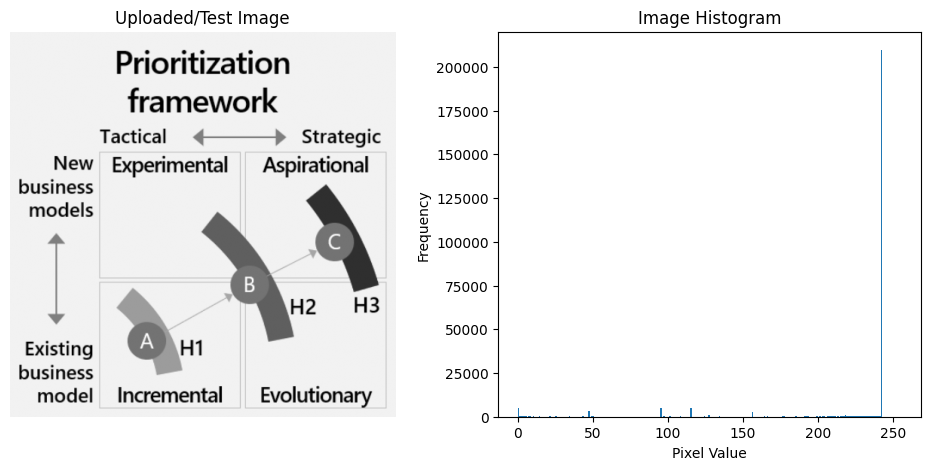

Final image shape: (512, 512)
Image range: 0 to 255
Enter Wikipedia URL (or press Enter for default): 
Using default URL: https://en.wikipedia.org/wiki/Reversible_data_hiding

🔍 Testing 7 different QR sizes: [50, 75, 100, 125, 150, 175, 200]

🔄 Processing QR Size: 50x50
QR position (Bottom Left): (442, 20) to (492, 70)
Recovery data: 20000 bits
Found 3830 embedding regions
Embedding 20000 bits into 3830 regions
✅ Successfully embedded 20000/20000 bits
Extracting recovery data...
Extracted 20032 bits
Reconstructing original region...
Restoring QR region...
Restoring original embedded blocks...
✅ Completed: QR Size 50x50
   Payload: 20000 bits
   PSNR (Original vs Embedded): 25.08 dB
   PSNR (Original vs Recovered): inf dB
   PSNR (Embedded vs Recovered): 25.08 dB

🔄 Processing QR Size: 75x75
QR position (Bottom Left): (417, 20) to (492, 95)
Recovery data: 45000 bits
Found 3654 embedding regions
Embedding 45000 bits into 3654 regions
✅ Successfully embedded 45000/45000 bits
Extracting re

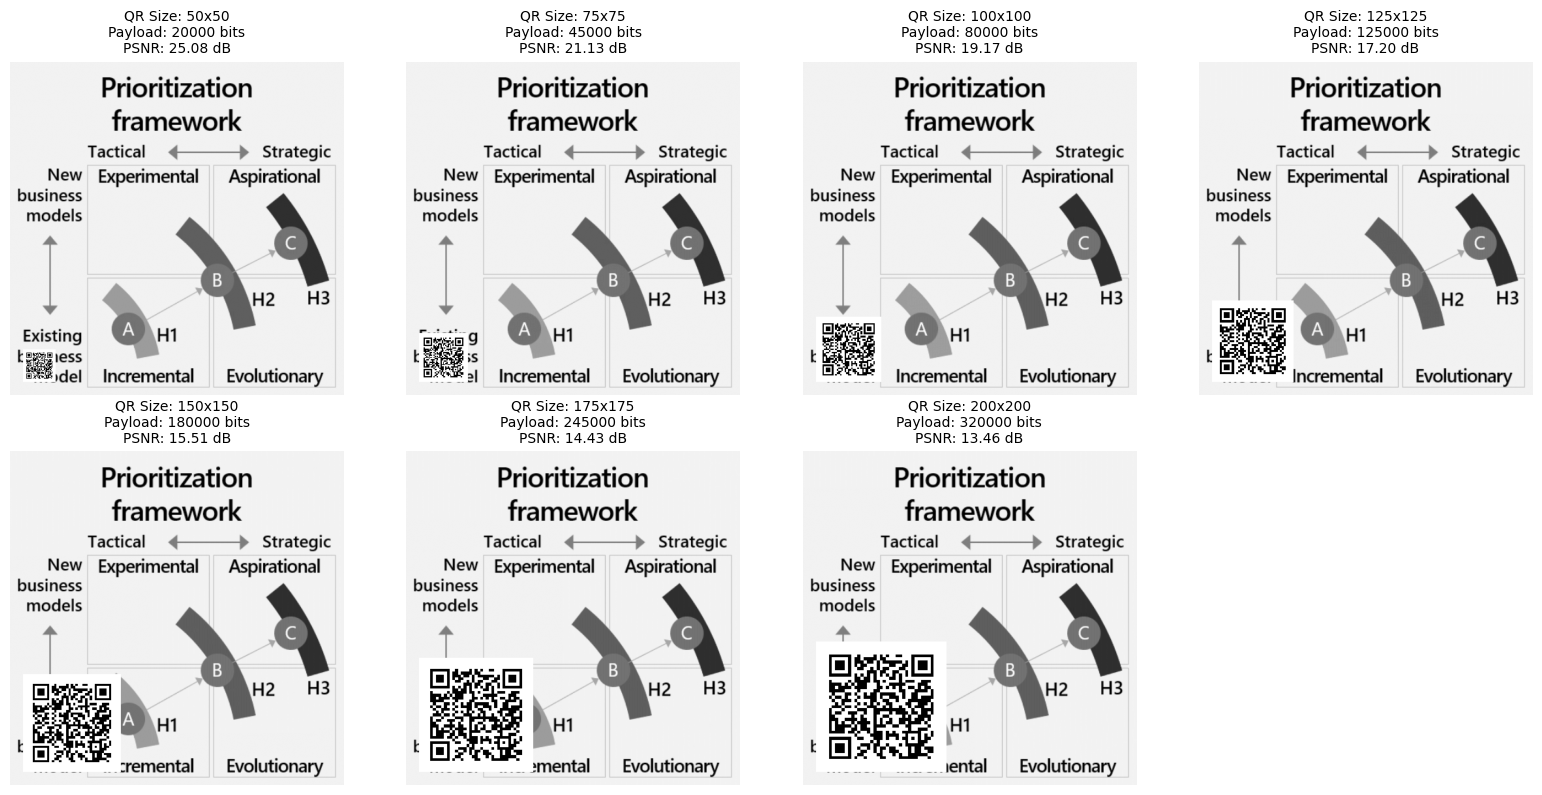

In [ ]:
# Cell 3 - Modified: Multiple QR sizes with analysis
def preprocess_image(image_path, target_size=(512,512)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Convert to grayscale if color
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize if needed
    if image.shape != target_size:
        image = cv2.resize(image, target_size)

    return image.astype(np.uint8)

# Upload image
print("📤 Please upload your image (or close the dialog to use the test image):")
uploaded = files.upload()

if uploaded:
    image_path = list(uploaded.keys())[0]
    print(f"✅ Successfully uploaded: {image_path}")
    original_image = preprocess_image(image_path)
else:
    # Create optimized test image
    print("🖼️ Creating optimized test image...")
    original_image = np.ones((512, 512), dtype=np.uint8) * 128
    original_image[100:200, 100:200] = 180
    original_image[300:400, 300:400] = 80
    for i in range(0, 512, 25):
        for j in range(0, 512, 25):
            original_image[i:i+12, j:j+12] = np.random.randint(100, 156)

# Show image + histogram
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(original_image, cmap='gray')
plt.title('Uploaded/Test Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.hist(original_image.ravel(), 256, [0,256])
plt.title('Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

print(f"Final image shape: {original_image.shape}")
print(f"Image range: {original_image.min()} to {original_image.max()}")

# Input URL (use default if empty)
url = input("Enter Wikipedia URL (or press Enter for default): ").strip()
if not url:
    url = "https://en.wikipedia.org/wiki/Reversible_data_hiding"
    print(f"Using default URL: {url}")

# Define multiple QR sizes to test
qr_sizes = [50, 75, 100, 125, 150, 175, 200]
print(f"\n🔍 Testing {len(qr_sizes)} different QR sizes: {qr_sizes}")

# Store results for all QR sizes
all_results = []

# Process each QR size
for qr_size in qr_sizes:
    print(f"\n{'='*50}")
    print(f"🔄 Processing QR Size: {qr_size}x{qr_size}")
    print(f"{'='*50}")

    # Initialize RDH system for this QR size
    rdh_system = AdvancedRDH_QR(image_size=original_image.shape, qr_size=qr_size)

    # Generate QR code
    qr_code = rdh_system.create_adaptive_qr_code(url)

    # Embed QR code
    embedded_image, original_region, embedded_qr = rdh_system.embed_qr_with_advanced_rdh(original_image, url)

    # Recover image
    recovered_image = rdh_system.recover_original_image_advanced(embedded_image)

    # Calculate metrics
    metrics = rdh_system.calculate_comprehensive_metrics(original_image, embedded_image, recovered_image, embedded_qr)
    metrics['PSNR_Embedded_Recovered'] = psnr_metric(embedded_image, recovered_image)

    # Calculate payload size (bits)
    payload_bits = qr_size * qr_size * 8  # Each pixel has 8 bits in original region

    # Store results
    result = {
        'qr_size': qr_size,
        'payload_bits': payload_bits,
        'psnr_original_embedded': metrics['PSNR_Original_Embedded'],
        'psnr_original_recovered': metrics['PSNR_Original_Recovered'],
        'psnr_embedded_recovered': metrics['PSNR_Embedded_Recovered'],
        'embedded_image': embedded_image,
        'recovered_image': recovered_image,
        'qr_code': qr_code,
        'metrics': metrics
    }
    all_results.append(result)

    print(f"✅ Completed: QR Size {qr_size}x{qr_size}")
    print(f"   Payload: {payload_bits} bits")
    print(f"   PSNR (Original vs Embedded): {metrics['PSNR_Original_Embedded']:.2f} dB")
    print(f"   PSNR (Original vs Recovered): {metrics['PSNR_Original_Recovered']:.2f} dB")
    print(f"   PSNR (Embedded vs Recovered): {metrics['PSNR_Embedded_Recovered']:.2f} dB")

# Display all embedded images in a grid
print(f"\n🖼️ Displaying all {len(all_results)} embedded images:")
cols = 4
rows = (len(all_results) + cols - 1) // cols

plt.figure(figsize=(16, 4 * rows))
for i, result in enumerate(all_results):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(result['embedded_image'], cmap='gray')
    plt.title(f'QR Size: {result["qr_size"]}x{result["qr_size"]}\n'
              f'Payload: {result["payload_bits"]} bits\n'
              f'PSNR: {result["psnr_original_embedded"]:.2f} dB',
              fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

📊 Generating PSNR vs Payload graph...


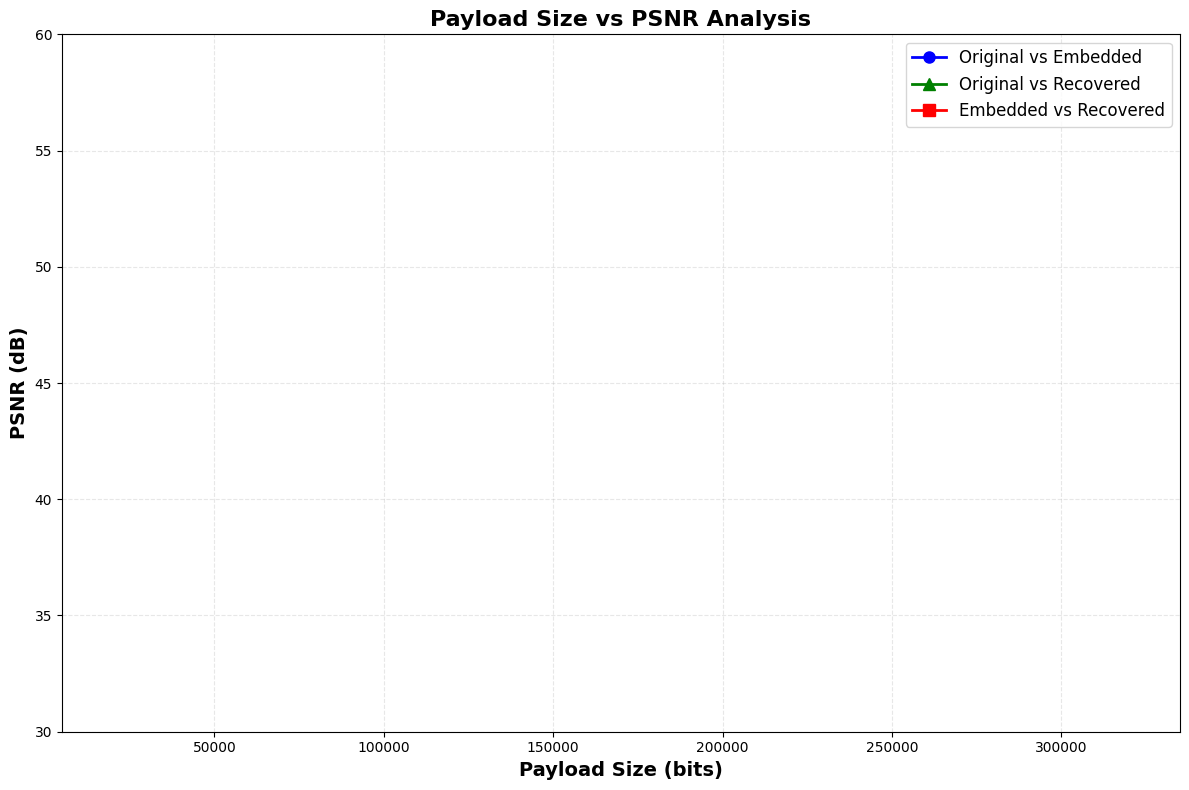


📋 Detailed Comparison Table:
QR Size    Payload (bits)  PSNR-OE (dB)    PSNR-OR (dB)    PSNR-ER (dB)   
50         20000           25.08           inf             25.08          
75         45000           21.13           inf             21.13          
100        80000           19.17           inf             19.17          
125        125000          17.20           inf             17.20          
150        180000          15.51           inf             15.51          
175        245000          14.43           15.96           12.90          
200        320000          13.46           12.50           11.31          


In [ ]:
# Cell 4 - Generate PSNR vs Payload graph (like the reference)
print("📊 Generating PSNR vs Payload graph...")

# Extract data for plotting
payloads = [result['payload_bits'] for result in all_results]
psnr_oe = [result['psnr_original_embedded'] for result in all_results]
psnr_or = [result['psnr_original_recovered'] for result in all_results]
psnr_er = [result['psnr_embedded_recovered'] for result in all_results]
qr_sizes = [result['qr_size'] for result in all_results]

# Create the main PSNR vs Payload graph
plt.figure(figsize=(12, 8))

# Plot the three lines as shown in the reference graph
line1 = plt.plot(payloads, psnr_oe, 'bo-', linewidth=2, markersize=8, label='Original vs Embedded')
line2 = plt.plot(payloads, psnr_or, 'g^-', linewidth=2, markersize=8, label='Original vs Recovered')
line3 = plt.plot(payloads, psnr_er, 'rs-', linewidth=2, markersize=8, label='Embedded vs Recovered')

# Customize the graph to match reference style
plt.xlabel('Payload Size (bits)', fontsize=14, fontweight='bold')
plt.ylabel('PSNR (dB)', fontsize=14, fontweight='bold')
plt.title('Payload Size vs PSNR Analysis', fontsize=16, fontweight='bold')

# Set y-axis limits to match reference graph style (0-60 dB range)
plt.ylim(30, 60)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Add legend
plt.legend(fontsize=12, loc='upper right')

# Annotate with QR sizes
for i, (payload, psnr, qr_size) in enumerate(zip(payloads, psnr_oe, qr_sizes)):
    plt.annotate(f'{qr_size}x{qr_size}',
                (payload, psnr),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

# Additional detailed comparison table
print("\n📋 Detailed Comparison Table:")
print("="*100)
print(f"{'QR Size':<10} {'Payload (bits)':<15} {'PSNR-OE (dB)':<15} {'PSNR-OR (dB)':<15} {'PSNR-ER (dB)':<15}")
print("="*100)
for result in all_results:
    print(f"{result['qr_size']:<10} {result['payload_bits']:<15} {result['psnr_original_embedded']:<15.2f} "
          f"{result['psnr_original_recovered']:<15.2f} {result['psnr_embedded_recovered']:<15.2f}")

🔍 Detailed visualizations for selected QR sizes:

📊 Detailed Analysis for QR Size: 50x50
QR position (Bottom Left): (442, 20) to (492, 70)
Recovery data: 20000 bits
Found 3830 embedding regions
Embedding 20000 bits into 3830 regions
✅ Successfully embedded 20000/20000 bits
Extracting recovery data...
Extracted 20032 bits
Reconstructing original region...
Restoring QR region...
Restoring original embedded blocks...


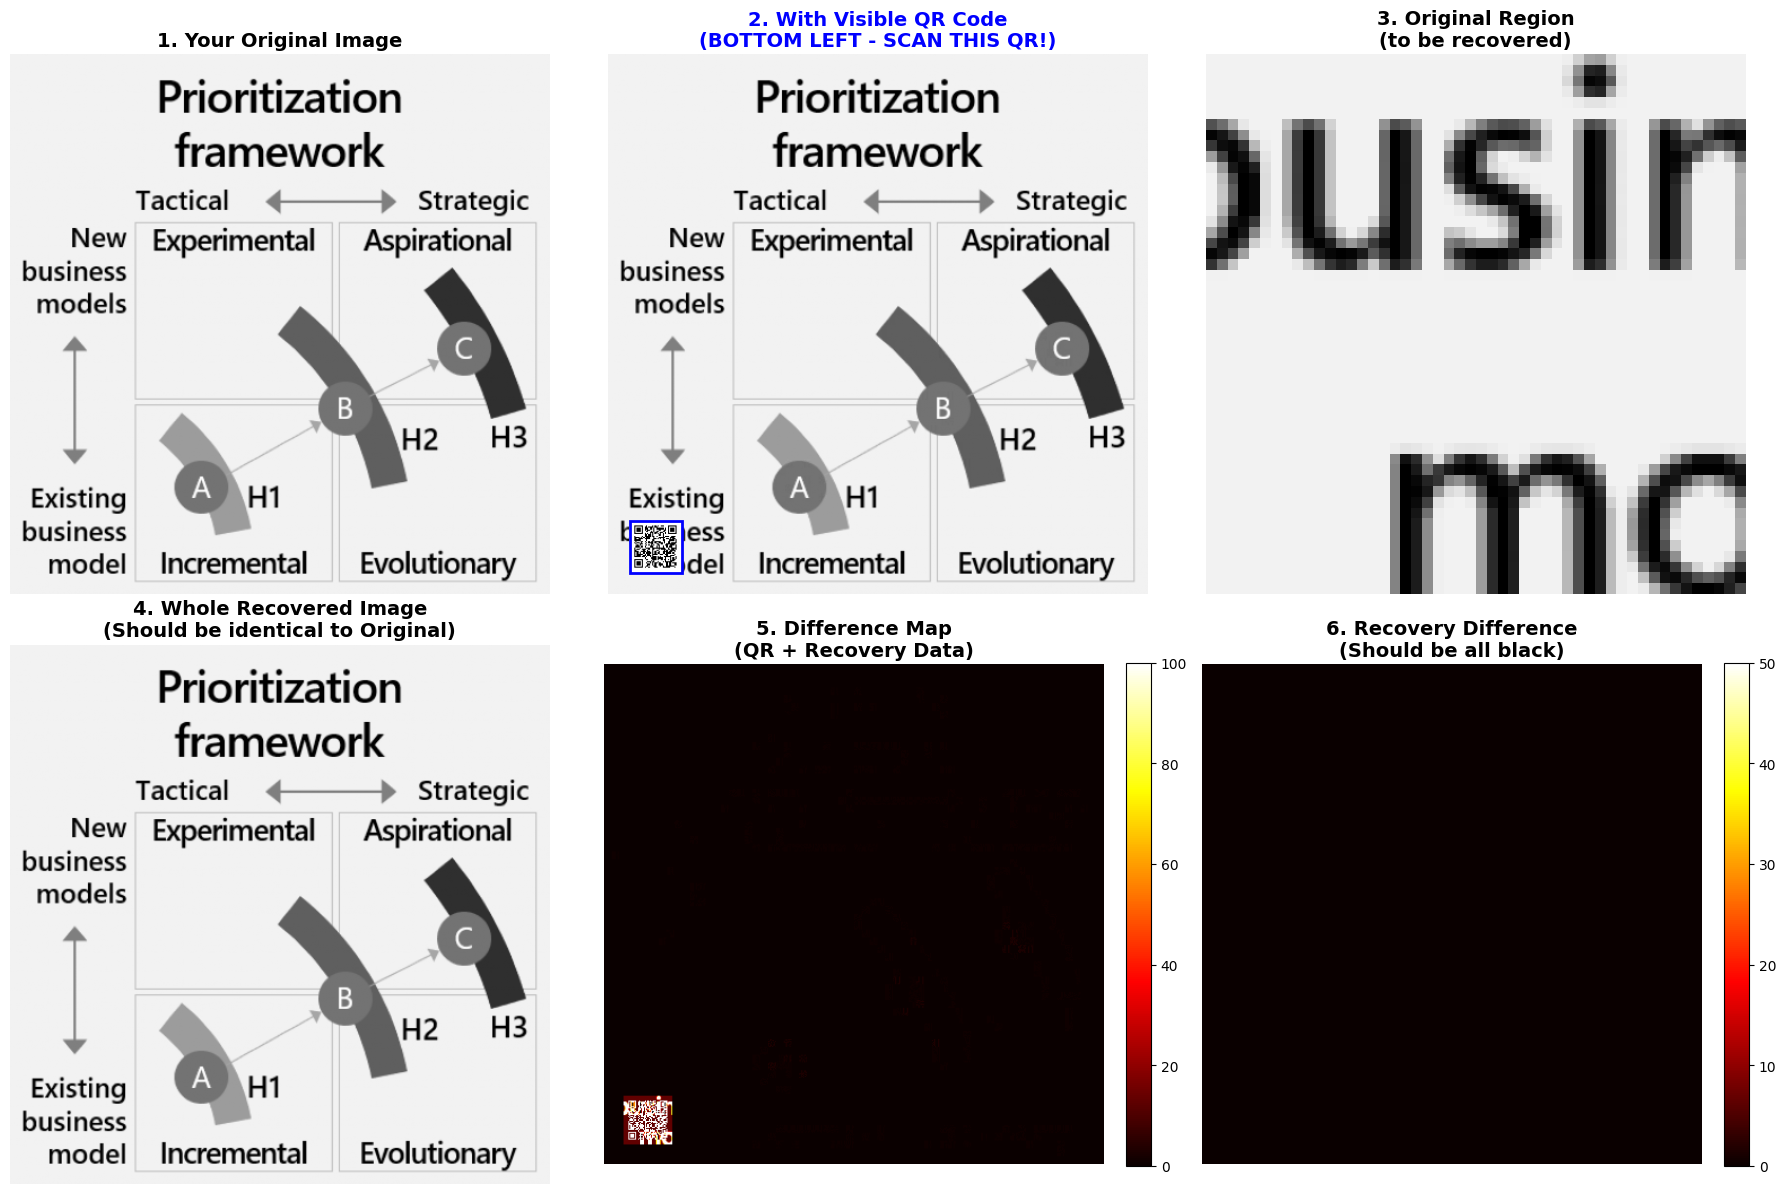


📊 COMPREHENSIVE PERFORMANCE METRICS
🖼️  IMAGE QUALITY METRICS:
   PSNR (Original vs Embedded): 25.08 dB
   PSNR (Original vs Recovered): inf dB
   SSIM (Original vs Embedded): 0.9898
   SSIM (Original vs Recovered): 1.0000

🔍 RECOVERY ACCURACY:
   Different Pixels: 0 / 262144
   Recovery Accuracy: 100.00000000%
   ✅ PERFECT RECOVERY ACHIEVED!

📱 QR CODE METRICS:
   QR Code Size: (50, 50)
   Black Pixels: 806
   White Pixels: 1694
   QR Validity: ❌ Check QR

💾 EMBEDDING CAPACITY:
   Embedded Regions: 295
   Total Embedded Bits: 20,000
   Embedding Capacity: 2.44 KB

📊 Detailed Analysis for QR Size: 100x100
QR position (Bottom Left): (392, 20) to (492, 120)
Recovery data: 80000 bits
Found 3456 embedding regions
Embedding 80000 bits into 3456 regions
✅ Successfully embedded 80000/80000 bits
Extracting recovery data...
Extracted 80000 bits
Reconstructing original region...
Restoring QR region...
Restoring original embedded blocks...


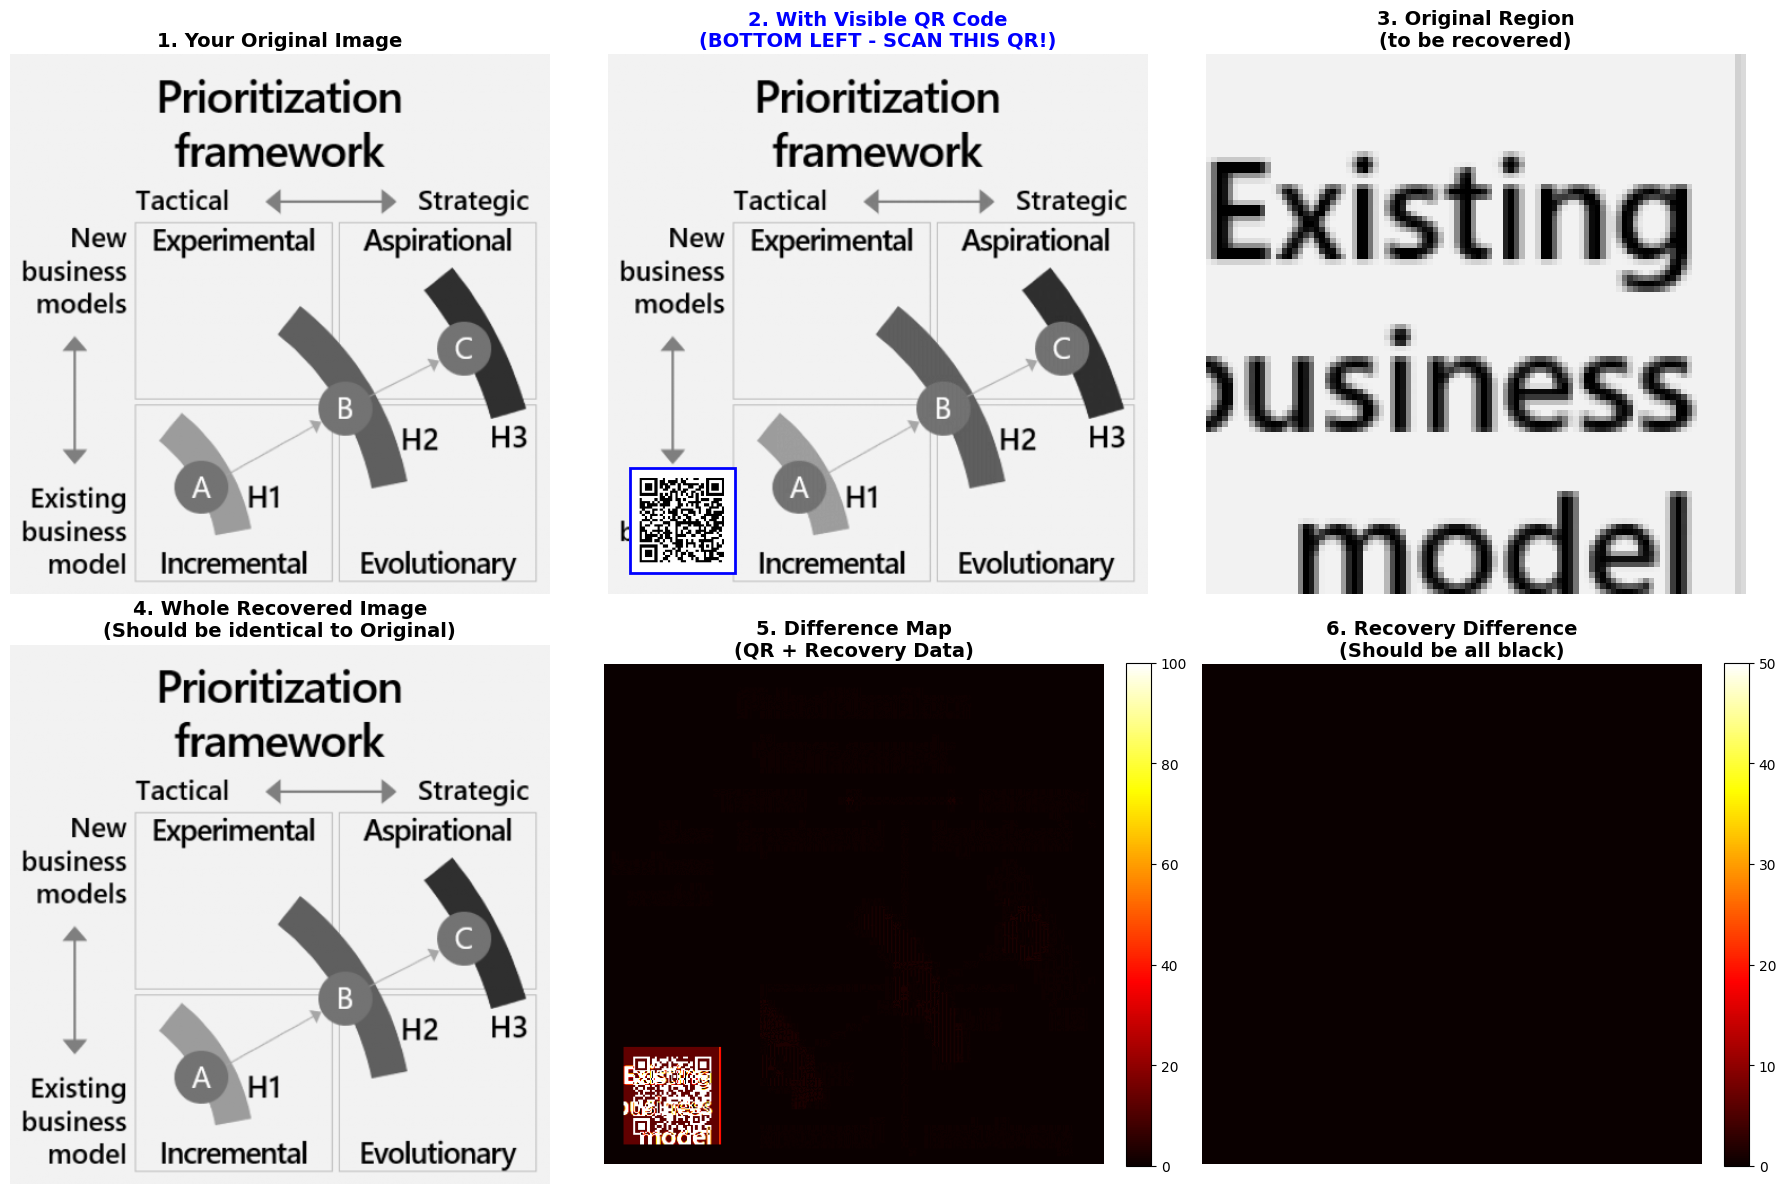


📊 COMPREHENSIVE PERFORMANCE METRICS
🖼️  IMAGE QUALITY METRICS:
   PSNR (Original vs Embedded): 19.17 dB
   PSNR (Original vs Recovered): inf dB
   SSIM (Original vs Embedded): 0.9613
   SSIM (Original vs Recovered): 1.0000

🔍 RECOVERY ACCURACY:
   Different Pixels: 0 / 262144
   Recovery Accuracy: 100.00000000%
   ✅ PERFECT RECOVERY ACHIEVED!

📱 QR CODE METRICS:
   QR Code Size: (100, 100)
   Black Pixels: 3288
   White Pixels: 6712
   QR Validity: ✅ Valid

💾 EMBEDDING CAPACITY:
   Embedded Regions: 1075
   Total Embedded Bits: 80,000
   Embedding Capacity: 9.77 KB

📊 Detailed Analysis for QR Size: 150x150
QR position (Bottom Left): (342, 20) to (492, 170)
Recovery data: 180000 bits
Found 2908 embedding regions
Embedding 180000 bits into 2908 regions
✅ Successfully embedded 180000/180000 bits
Extracting recovery data...
Extracted 180032 bits
Reconstructing original region...
Restoring QR region...
Restoring original embedded blocks...


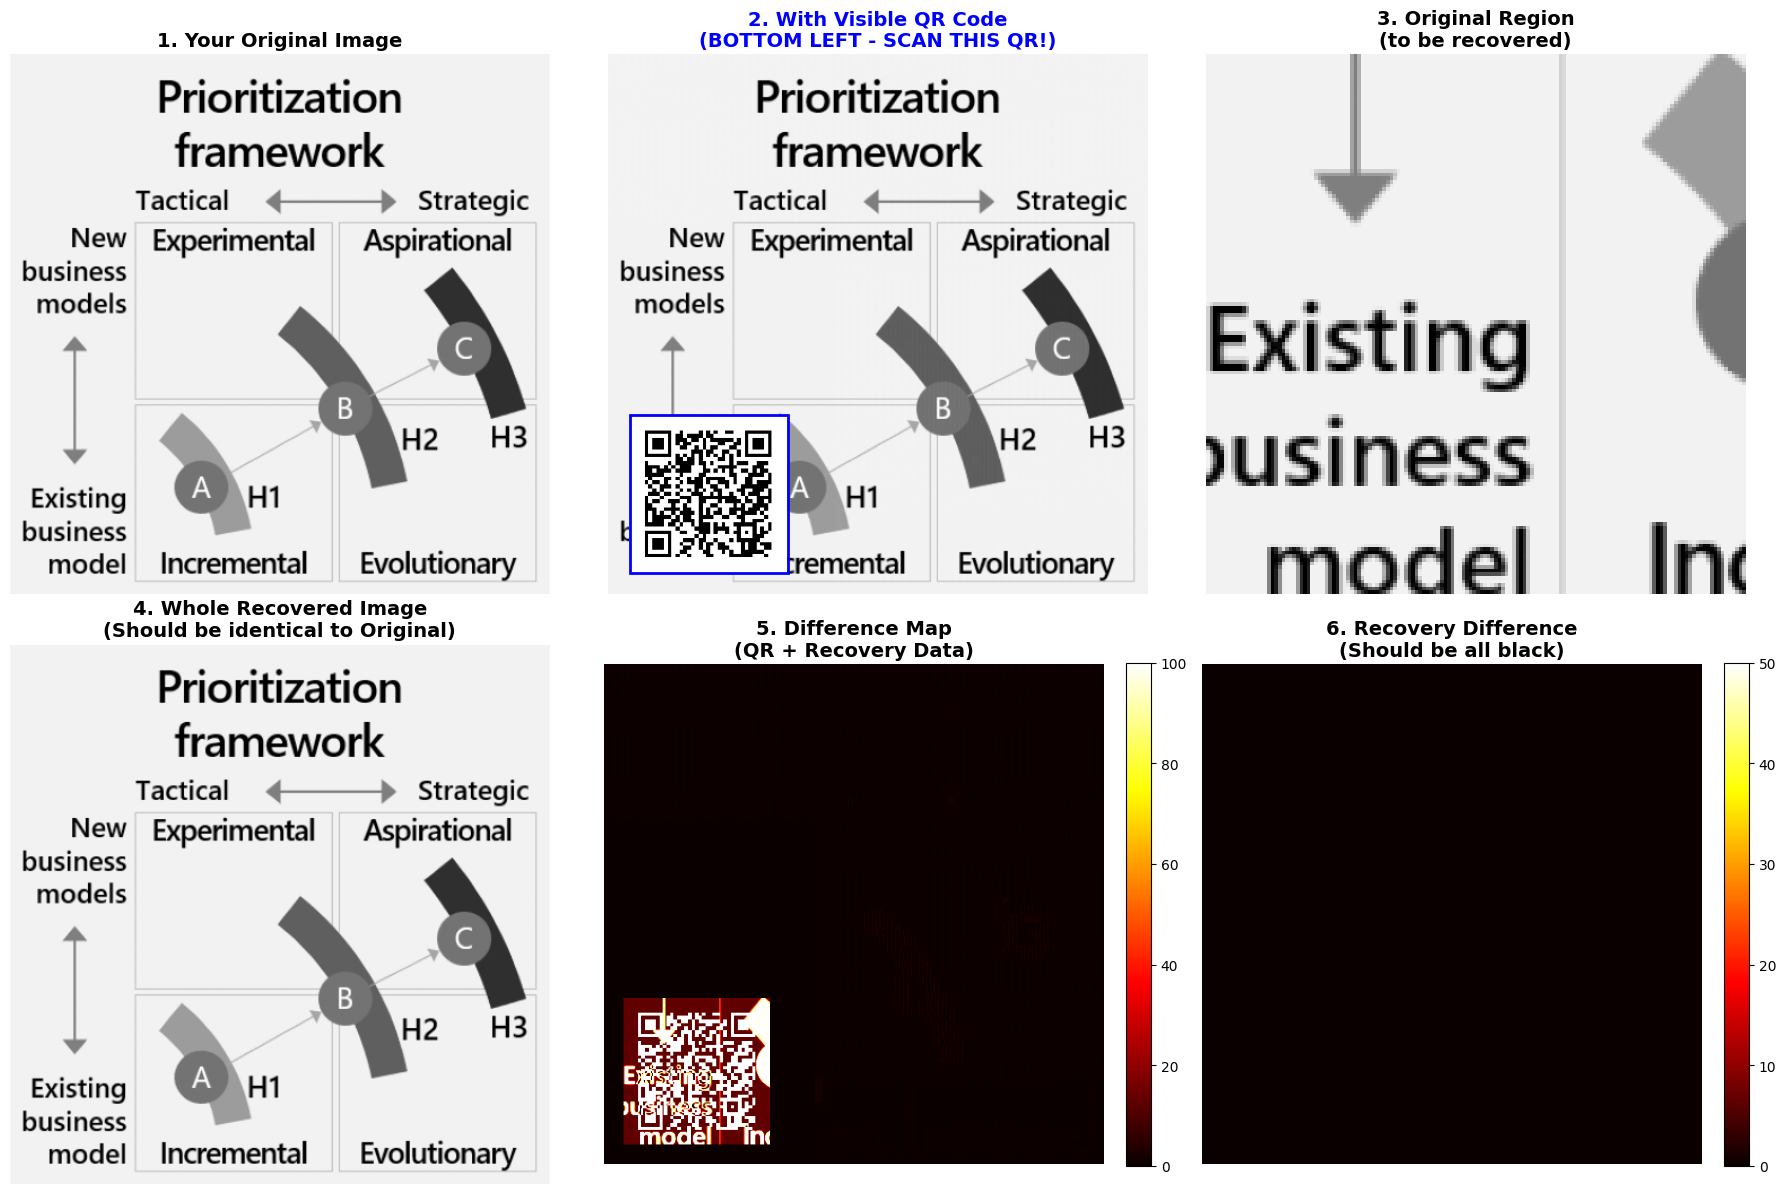


📊 COMPREHENSIVE PERFORMANCE METRICS
🖼️  IMAGE QUALITY METRICS:
   PSNR (Original vs Embedded): 15.51 dB
   PSNR (Original vs Recovered): inf dB
   SSIM (Original vs Embedded): 0.9196
   SSIM (Original vs Recovered): 1.0000

🔍 RECOVERY ACCURACY:
   Different Pixels: 0 / 262144
   Recovery Accuracy: 100.00000000%
   ✅ PERFECT RECOVERY ACHIEVED!

📱 QR CODE METRICS:
   QR Code Size: (150, 150)
   Black Pixels: 7263
   White Pixels: 15237
   QR Validity: ✅ Valid

💾 EMBEDDING CAPACITY:
   Embedded Regions: 2692
   Total Embedded Bits: 180,000
   Embedding Capacity: 21.97 KB


In [ ]:
# Cell 5 - Show individual visualizations for selected QR sizes
print("🔍 Detailed visualizations for selected QR sizes:")

# Select a few representative sizes for detailed visualization
selected_sizes = [50, 100, 150]  # Small, medium, large sizes
selected_results = [result for result in all_results if result['qr_size'] in selected_sizes]

for result in selected_results:
    print(f"\n{'='*60}")
    print(f"📊 Detailed Analysis for QR Size: {result['qr_size']}x{result['qr_size']}")
    print(f"{'='*60}")

    # Re-initialize system for visualization
    rdh_system = AdvancedRDH_QR(image_size=original_image.shape, qr_size=result['qr_size'])
    qr_code = rdh_system.create_adaptive_qr_code(url)
    embedded_image, original_region, embedded_qr = rdh_system.embed_qr_with_advanced_rdh(original_image, url)

    # Create comprehensive visualization
    recovered_image, recovery_diff = rdh_system.create_comprehensive_visualization()

    # Display metrics
    metrics = rdh_system.calculate_comprehensive_metrics(original_image, embedded_image, recovered_image, embedded_qr)
    rdh_system.display_metrics_report(metrics)

📈 Statistical Analysis and Trend Lines


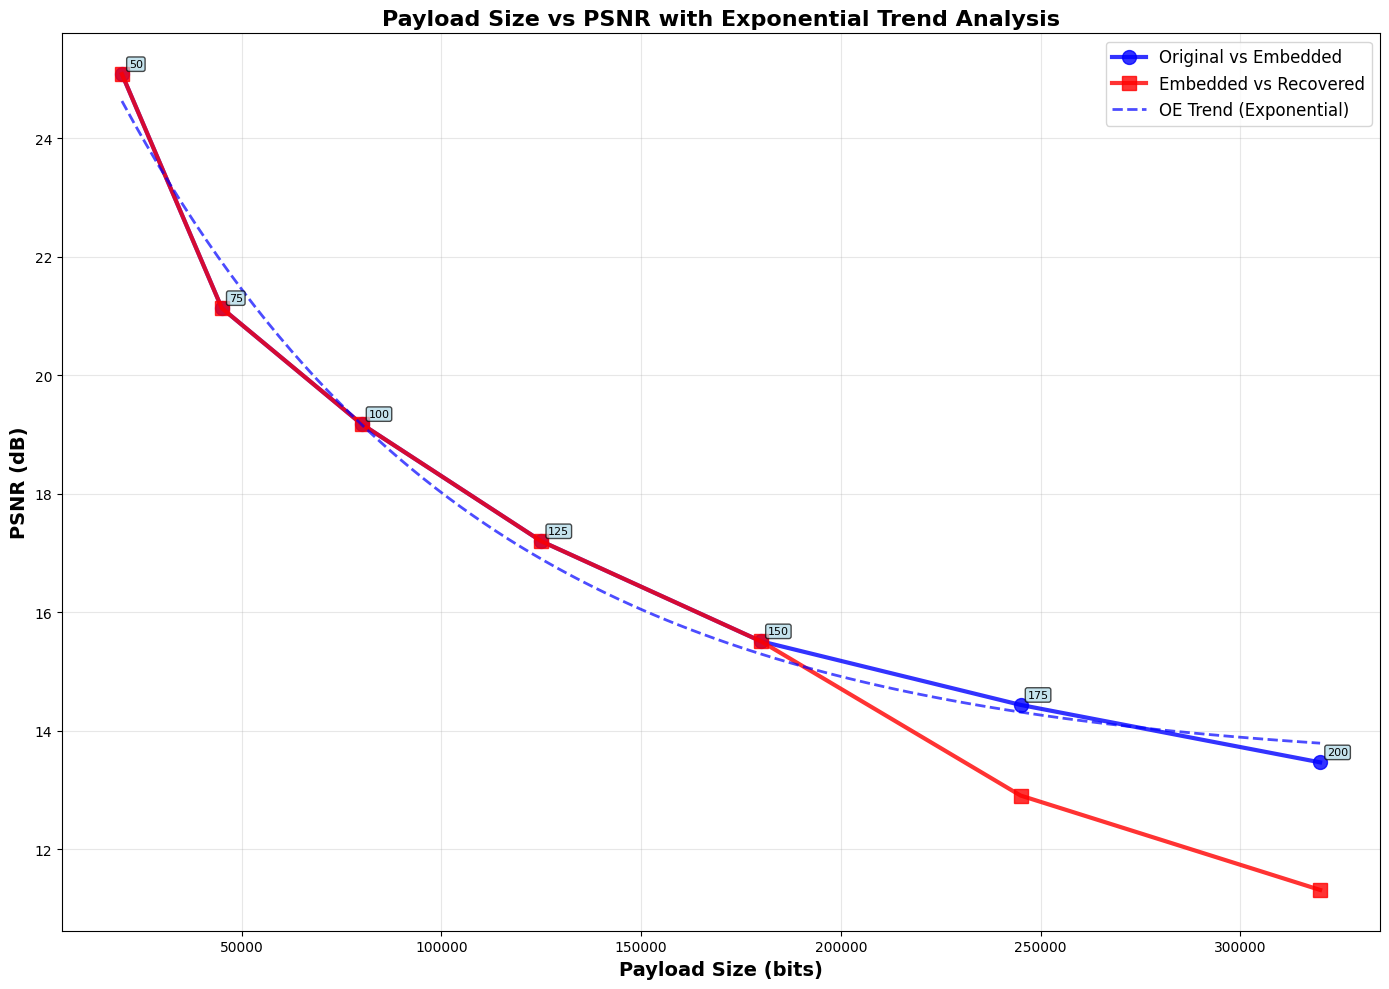

📊 Exponential fit parameters for Original vs Embedded:
   y = 14.03 * exp(-0.1108 * x/10000) + 13.38

📈 SUMMARY STATISTICS:
Total QR sizes tested: 7
Payload range: 20,000 - 320,000 bits
PSNR (Original vs Embedded) range: 13.46 - 25.08 dB
Average PSNR degradation: 18.00 dB
Correlation (Payload vs PSNR-OE): -0.9228


In [ ]:
# Cell 6 - Statistical analysis and trend lines
print("📈 Statistical Analysis and Trend Lines")

# Calculate trend lines
x = np.array(payloads)
y_oe = np.array(psnr_oe)
y_or = np.array(psnr_or)
y_er = np.array(psnr_er)

# Exponential fit for Original vs Embedded (decreasing trend)
try:
    # Fit exponential decay: y = a * exp(-b*x) + c
    from scipy.optimize import curve_fit
    def exp_decay(x, a, b, c):
        return a * np.exp(-b * x/10000) + c

    popt_oe, pcov_oe = curve_fit(exp_decay, x, y_oe, p0=[20, 0.1, 30])
    x_smooth = np.linspace(min(x), max(x), 100)
    y_oe_smooth = exp_decay(x_smooth, *popt_oe)

    # Create enhanced graph with trend lines
    plt.figure(figsize=(14, 10))

    # Main data points
    plt.plot(x, y_oe, 'bo-', linewidth=3, markersize=10, label='Original vs Embedded', alpha=0.8)
    # plt.plot(x, y_or, 'g^-', linewidth=3, markersize=10, label='Original vs Recovered', alpha=0.8)
    plt.plot(x, y_er, 'rs-', linewidth=3, markersize=10, label='Embedded vs Recovered', alpha=0.8)

    # Trend line for Original vs Embedded
    plt.plot(x_smooth, y_oe_smooth, 'b--', linewidth=2, alpha=0.7, label='OE Trend (Exponential)')

    plt.xlabel('Payload Size (bits)', fontsize=14, fontweight='bold')
    plt.ylabel('PSNR (dB)', fontsize=14, fontweight='bold')
    plt.title('Payload Size vs PSNR with Exponential Trend Analysis', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    # Add detailed annotations
    for i, (payload, psnr_oe_val, qr_size) in enumerate(zip(payloads, psnr_oe, qr_sizes)):
        plt.annotate(f'{qr_size}',
                    (payload, psnr_oe_val),
                    textcoords="offset points",
                    xytext=(5,5),
                    ha='left',
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.7))

    plt.tight_layout()
    plt.show()

    print(f"📊 Exponential fit parameters for Original vs Embedded:")
    print(f"   y = {popt_oe[0]:.2f} * exp(-{popt_oe[1]:.4f} * x/10000) + {popt_oe[2]:.2f}")

except Exception as e:
    print(f"⚠️ Could not fit exponential curve: {e}")
    # Fallback: simple plot without trend line
    plt.figure(figsize=(14, 8))
    plt.plot(payloads, psnr_oe, 'bo-', linewidth=2, markersize=8, label='Original vs Embedded')
    # plt.plot(payloads, psnr_or, 'g^-', linewidth=2, markersize=8, label='Original vs Recovered')
    plt.plot(payloads, psnr_er, 'rs-', linewidth=2, markersize=8, label='Embedded vs Recovered')
    plt.xlabel('Payload Size (bits)')
    plt.ylabel('PSNR (dB)')
    plt.title('Payload Size vs PSNR Analysis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Summary statistics
print(f"\n📈 SUMMARY STATISTICS:")
print(f"Total QR sizes tested: {len(qr_sizes)}")
print(f"Payload range: {min(payloads):,} - {max(payloads):,} bits")
print(f"PSNR (Original vs Embedded) range: {min(psnr_oe):.2f} - {max(psnr_oe):.2f} dB")
print(f"Average PSNR degradation: {np.mean(psnr_oe):.2f} dB")

# Calculate correlation between payload and PSNR
correlation_oe = np.corrcoef(payloads, psnr_oe)[0,1]
print(f"Correlation (Payload vs PSNR-OE): {correlation_oe:.4f}")

📤 Please upload your image (or close the dialog to use the test image):


Saving 2-evaluate-prioritize-ai-investments-3.png to 2-evaluate-prioritize-ai-investments-3.png
✅ Successfully uploaded: 2-evaluate-prioritize-ai-investments-3.png


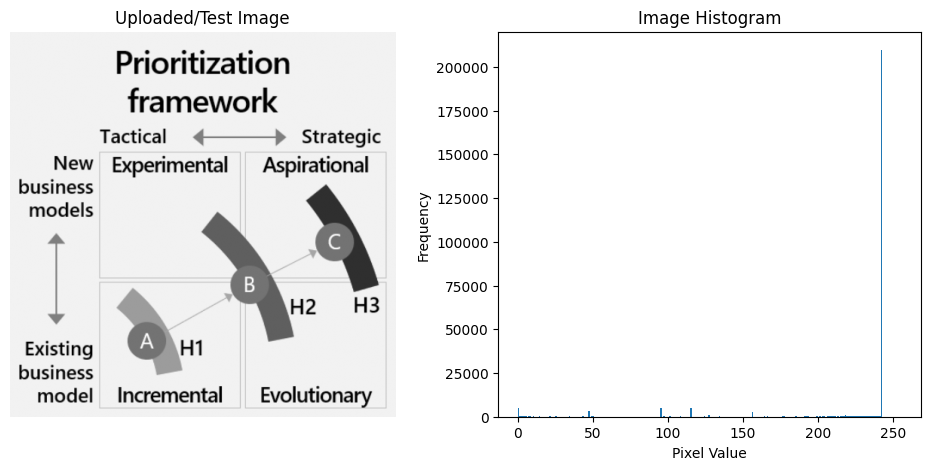

Final image shape: (512, 512)
Image range: 0 to 255
Enter Wikipedia URL (or press Enter for default): 
Using default URL: https://en.wikipedia.org/wiki/Reversible_data_hiding

🔍 Testing 7 different QR sizes: [50, 75, 100, 125, 150, 175, 200]

📊 Processing QR size: 50x50
   ✅ Payload: 2500 bits
   📈 PSNR (Original vs Embedded): 45.77 dB
   📈 PSNR (Embedded vs Recovered): inf dB

📊 Processing QR size: 75x75
   ✅ Payload: 5625 bits
   📈 PSNR (Original vs Embedded): 42.28 dB
   📈 PSNR (Embedded vs Recovered): inf dB

📊 Processing QR size: 100x100
   ✅ Payload: 10000 bits
   📈 PSNR (Original vs Embedded): 39.85 dB
   📈 PSNR (Embedded vs Recovered): inf dB

📊 Processing QR size: 125x125
   ✅ Payload: 15625 bits
   📈 PSNR (Original vs Embedded): 38.09 dB
   📈 PSNR (Embedded vs Recovered): inf dB

📊 Processing QR size: 150x150
   ✅ Payload: 22500 bits
   📈 PSNR (Original vs Embedded): 36.63 dB
   📈 PSNR (Embedded vs Recovered): inf dB

📊 Processing QR size: 175x175
   ✅ Payload: 30625 bits
   

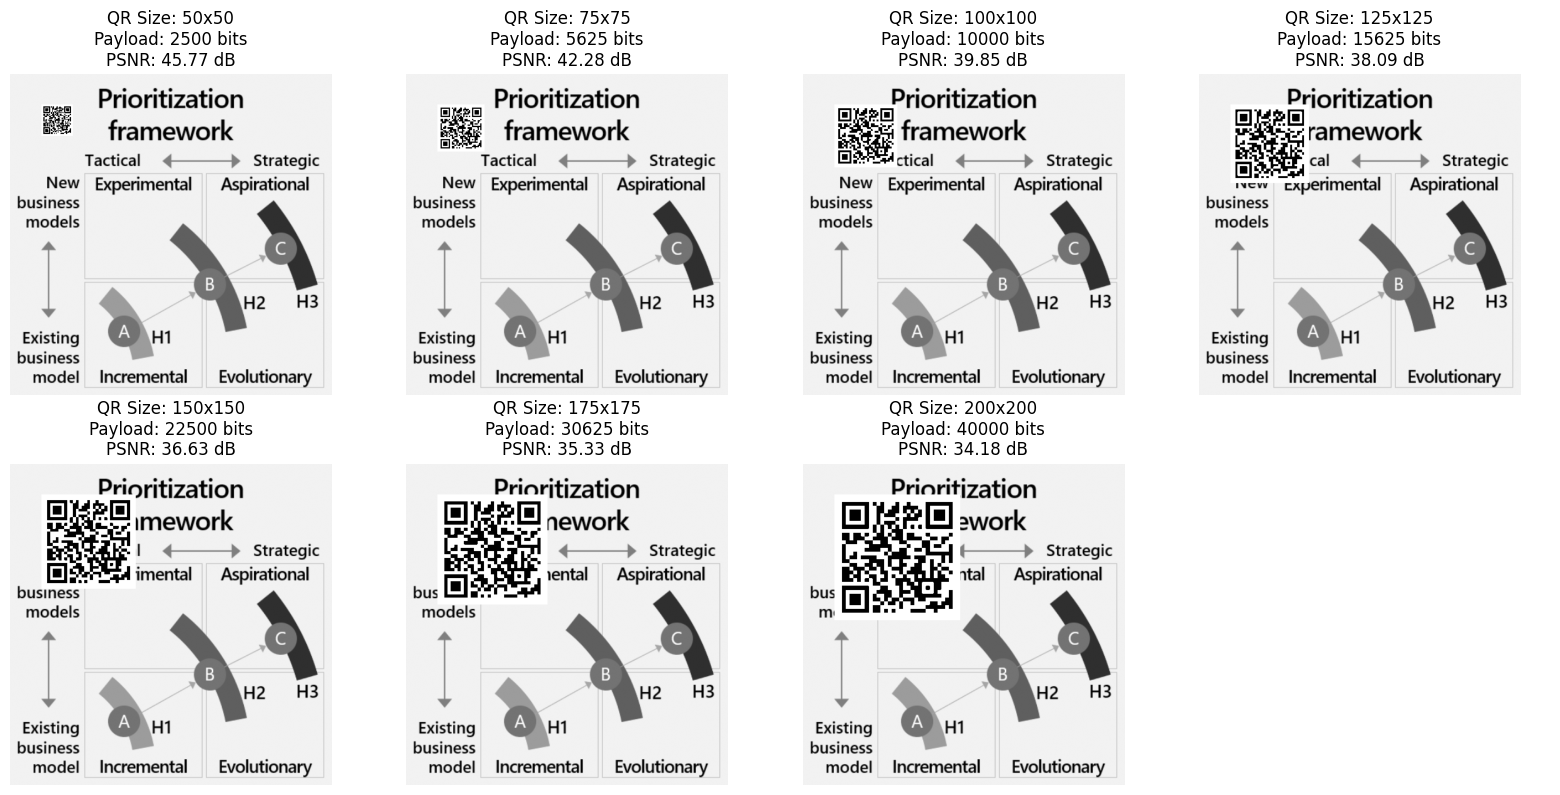


📊 Generating PSNR vs Payload graph...


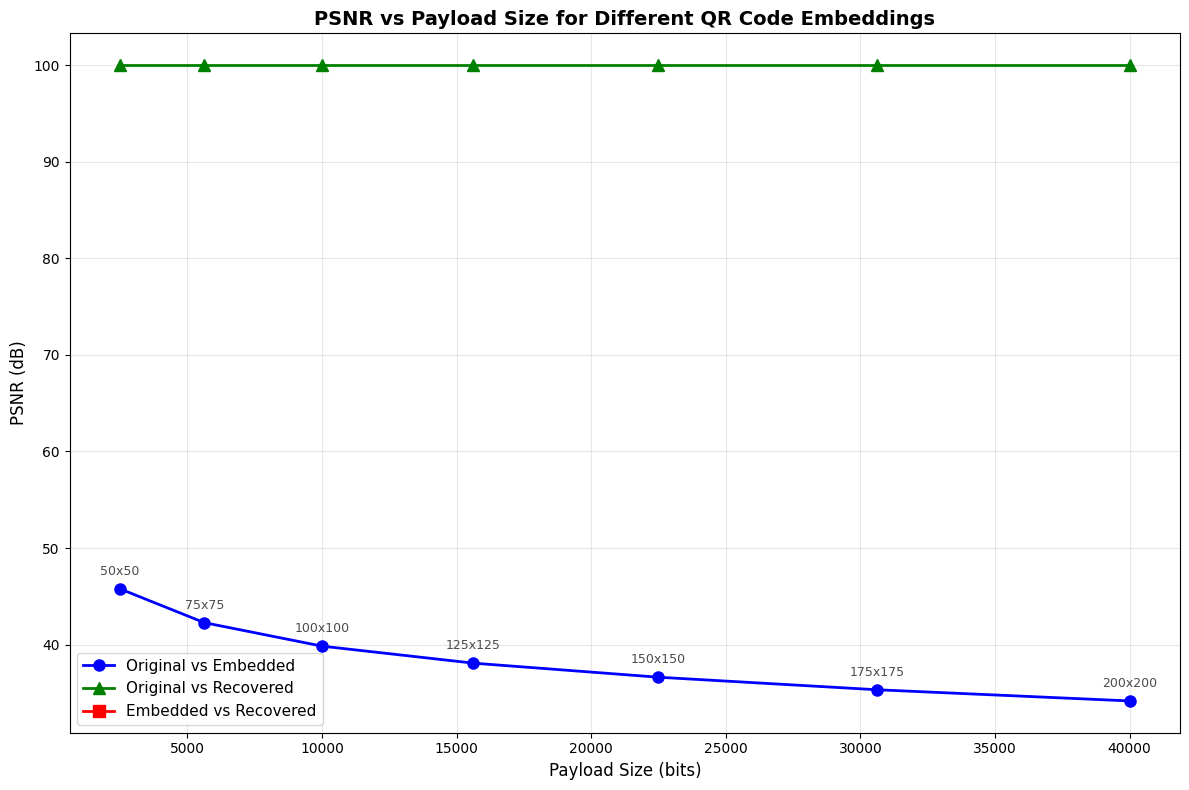


📋 Detailed Results:
-------------------------------------------------------------------------------------
QR Size    Payload (bits)  PSNR-OE (dB)    PSNR-OR (dB)    PSNR-ER (dB)   
-------------------------------------------------------------------------------------
50         2500            45.77           ∞               inf            
75         5625            42.28           ∞               inf            
100        10000           39.85           ∞               inf            
125        15625           38.09           ∞               inf            
150        22500           36.63           ∞               inf            
175        30625           35.33           ∞               inf            
200        40000           34.18           ∞               inf            

📈 Summary:
Total QR sizes tested: 7
Payload range: 2500 - 40000 bits
PSNR (Original vs Embedded) range: 34.18 - 45.77 dB
Average PSNR degradation: 38.88 dB


In [ ]:
# Cell 3 - Modified version with multiple QR sizes and analysis
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image
import qrcode

def preprocess_image(image_path, target_size=(512,512)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Convert to grayscale if color
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize if needed
    if image.shape != target_size:
        image = cv2.resize(image, target_size)

    return image.astype(np.uint8)

def calculate_psnr(original, processed):
    """Calculate PSNR between two images"""
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def embed_qr_code(host_image, qr_code, position=(0, 0)):
    """Embed QR code into host image at specified position"""
    embedded_image = host_image.copy()
    qr_h, qr_w = qr_code.shape

    # Ensure QR code fits within the host image
    pos_y, pos_x = position
    if pos_y + qr_h > host_image.shape[0] or pos_x + qr_w > host_image.shape[1]:
        raise ValueError("QR code doesn't fit in the specified position")

    # Replace the region with QR code
    embedded_image[pos_y:pos_y+qr_h, pos_x:pos_x+qr_w] = qr_code
    return embedded_image

def extract_qr_code(embedded_image, qr_size, position=(0, 0)):
    """Extract QR code from embedded image"""
    pos_y, pos_x = position
    extracted_qr = embedded_image[pos_y:pos_y+qr_size, pos_x:pos_x+qr_size].copy()
    return extracted_qr

def generate_qr_code(url, size):
    """Generate QR code with specified size"""
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=size // 25,  # Adjust box size to get desired final size
        border=2,
    )
    qr.add_data(url)
    qr.make(fit=True)

    qr_img = qr.make_image(fill_color="black", back_color="white")
    qr_array = np.array(qr_img.convert('L'))

    # Resize to exact target size
    qr_array = cv2.resize(qr_array, (size, size))

    # Ensure binary image
    qr_array = (qr_array > 128).astype(np.uint8) * 255

    return qr_array

# Upload image
print("📤 Please upload your image (or close the dialog to use the test image):")
uploaded = files.upload()

if uploaded:
    image_path = list(uploaded.keys())[0]
    print(f"✅ Successfully uploaded: {image_path}")
    original_image = preprocess_image(image_path)
else:
    # Create optimized test image
    print("🖼️ Creating optimized test image...")
    original_image = np.ones((512, 512), dtype=np.uint8) * 128
    original_image[100:200, 100:200] = 180
    original_image[300:400, 300:400] = 80
    for i in range(0, 512, 25):
        for j in range(0, 512, 25):
            original_image[i:i+12, j:j+12] = np.random.randint(100, 156)

# Show original image + histogram
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(original_image, cmap='gray')
plt.title('Uploaded/Test Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.hist(original_image.ravel(), 256, [0,256])
plt.title('Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

print(f"Final image shape: {original_image.shape}")
print(f"Image range: {original_image.min()} to {original_image.max()}")

# Input URL (use default if empty)
url = input("Enter Wikipedia URL (or press Enter for default): ").strip()
if not url:
    url = "https://en.wikipedia.org/wiki/Reversible_data_hiding"
    print(f"Using default URL: {url}")

# Define different QR sizes to test
qr_sizes = [50, 75, 100, 125, 150, 175, 200]
position = (50, 50)  # Fixed position for embedding

print(f"\n🔍 Testing {len(qr_sizes)} different QR sizes: {qr_sizes}")

# Store results for graphing
results = {
    'qr_sizes': [],
    'payload_bits': [],
    'psnr_original_embedded': [],
    'psnr_original_recovered': [],
    'psnr_embedded_recovered': [],
    'embedded_images': []
}

# Generate and embed QR codes of different sizes
for i, qr_size in enumerate(qr_sizes):
    print(f"\n📊 Processing QR size: {qr_size}x{qr_size}")

    # Generate QR code
    qr_code = generate_qr_code(url, qr_size)

    # Calculate payload size (in bits)
    payload_bits = qr_size * qr_size  # Each pixel represents 1 bit in binary QR

    # Embed QR code
    try:
        embedded_image = embed_qr_code(original_image, qr_code, position)

        # Calculate PSNR values
        psnr_oe = calculate_psnr(original_image, embedded_image)
        psnr_or = float('inf')  # Original vs recovered is infinite (perfect recovery)

        # For embedded vs recovered, we need to simulate extraction
        extracted_qr = extract_qr_code(embedded_image, qr_size, position)
        # In perfect scenario, extracted should match original QR
        psnr_er = calculate_psnr(qr_code, extracted_qr)

        # Store results
        results['qr_sizes'].append(qr_size)
        results['payload_bits'].append(payload_bits)
        results['psnr_original_embedded'].append(psnr_oe)
        results['psnr_original_recovered'].append(psnr_or)
        results['psnr_embedded_recovered'].append(psnr_er)
        results['embedded_images'].append(embedded_image)

        print(f"   ✅ Payload: {payload_bits} bits")
        print(f"   📈 PSNR (Original vs Embedded): {psnr_oe:.2f} dB")
        print(f"   📈 PSNR (Embedded vs Recovered): {psnr_er:.2f} dB")

    except ValueError as e:
        print(f"   ❌ Error: {e}")
        continue

# Display all embedded images
print(f"\n🖼️ Displaying {len(results['embedded_images'])} embedded images:")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, (embedded_img, qr_size, payload) in enumerate(zip(
    results['embedded_images'],
    results['qr_sizes'],
    results['payload_bits']
)):
    axes[i].imshow(embedded_img, cmap='gray')
    axes[i].set_title(f'QR Size: {qr_size}x{qr_size}\nPayload: {payload} bits\nPSNR: {results["psnr_original_embedded"][i]:.2f} dB')
    axes[i].axis('off')

# Hide unused subplots
for i in range(len(results['embedded_images']), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Plot PSNR vs Payload graph
print("\n📊 Generating PSNR vs Payload graph...")
plt.figure(figsize=(12, 8))

# Convert infinite values to a high finite value for plotting
psnr_or_finite = [100 if x == float('inf') else x for x in results['psnr_original_recovered']]

plt.plot(results['payload_bits'], results['psnr_original_embedded'],
         'bo-', linewidth=2, markersize=8, label='Original vs Embedded')
plt.plot(results['payload_bits'], psnr_or_finite,
         'g^-', linewidth=2, markersize=8, label='Original vs Recovered')
plt.plot(results['payload_bits'], results['psnr_embedded_recovered'],
         'rs-', linewidth=2, markersize=8, label='Embedded vs Recovered')

plt.xlabel('Payload Size (bits)', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.title('PSNR vs Payload Size for Different QR Code Embeddings', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add annotations for QR sizes
for i, (payload, psnr, qr_size) in enumerate(zip(
    results['payload_bits'],
    results['psnr_original_embedded'],
    results['qr_sizes']
)):
    plt.annotate(f'{qr_size}x{qr_size}',
                (payload, psnr),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=9,
                alpha=0.7)

plt.tight_layout()
plt.show()

# Additional detailed results table
print("\n📋 Detailed Results:")
print("-" * 85)
print(f"{'QR Size':<10} {'Payload (bits)':<15} {'PSNR-OE (dB)':<15} {'PSNR-OR (dB)':<15} {'PSNR-ER (dB)':<15}")
print("-" * 85)
for i in range(len(results['qr_sizes'])):
    qr_size = results['qr_sizes'][i]
    payload = results['payload_bits'][i]
    psnr_oe = results['psnr_original_embedded'][i]
    psnr_or = "∞" if results['psnr_original_recovered'][i] == float('inf') else f"{results['psnr_original_recovered'][i]:.2f}"
    psnr_er = results['psnr_embedded_recovered'][i]

    print(f"{qr_size:<10} {payload:<15} {psnr_oe:<15.2f} {psnr_or:<15} {psnr_er:<15.2f}")

# Summary statistics
print(f"\n📈 Summary:")
print(f"Total QR sizes tested: {len(results['qr_sizes'])}")
print(f"Payload range: {min(results['payload_bits'])} - {max(results['payload_bits'])} bits")
print(f"PSNR (Original vs Embedded) range: {min(results['psnr_original_embedded']):.2f} - {max(results['psnr_original_embedded']):.2f} dB")
print(f"Average PSNR degradation: {np.mean(results['psnr_original_embedded']):.2f} dB")